<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2024

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [28]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2024.2.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy.git@main -q --upgrade
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q --upgrade
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

# ------------------------------
print('done')

installing pyTEMlib
done


**In Google Colab: Please restart runtime Ctrl+M**

### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../')
import SciFiReaders

import pyTEMlib
import pyTEMlib.file_tools     # File input/ output library
import pyTEMlib.eels_tools
import pyTEMlib.eds_tools


if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2024_2_20'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2024.01.1


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [2]:
fileWidget = pyTEMlib.file_tools.FileWidget()

### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

In [3]:
import h5py
file_name = '..\..\..\Example EDAX.edax.h5'
datasets = fileWidget.datasets
chooser = pyTEMlib.file_tools.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('RCOB-3,5Zn_Area5_LiveMap1_SpectrumImage: RCOB-3,5Zn_Area5_Li…

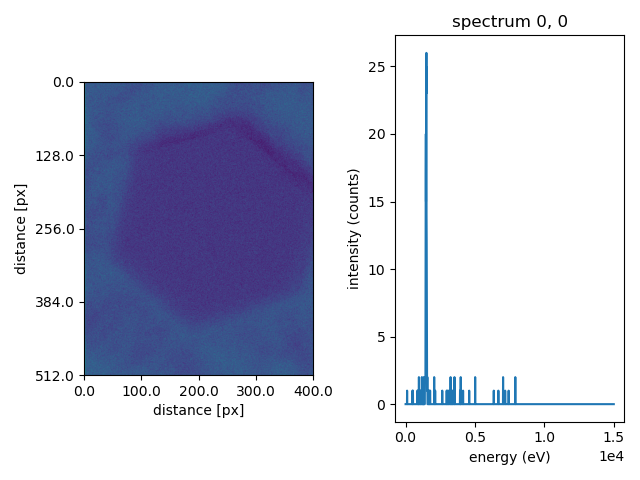

In [6]:
import scipy
d = chooser.dataset
v = d.plot()

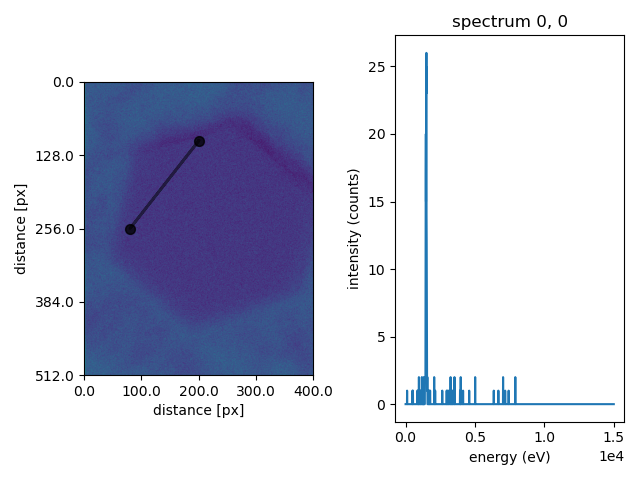

In [19]:

import pyTEMlib.image_tools


def get_profile(dataset, line):
    xv, yv = get_line_selection_points(line)
    
    if dataset.data_type.name == 'IMAGE':
        dataset.get_image_dims()
        profile = scipy.ndimage.map_coordinates(np.array(dataset.T), [xv,yv])
        
        profile_dataset = sidpy.Dataset.from_array(profile.sum(axis=0))
        profile_dataset.data_type='spectrum'
        profile_dataset.units = dataset.units
        profile_dataset.quantity = dataset.quantity
        profile_dataset.set_dimension(0, sidpy.Dimension(np.linspace(xv[0,0], xv[-1,-1], profile_dataset.shape[0]), 
                                                  name='x', units=dataset.x.units, quantity=dataset.x.quantity,
                                                  dimension_type='spatial'))

        profile_dataset

    if dataset.data_type.name == 'SPECTRAL_IMAGE':
        spectral_axis = dataset.get_spectral_dims(return_axis=True)[0]
        profile = np.zeros([xv.shape[1], 2, len(spectral_axis)])
        data =np.array(dataset)

        for index_x in range(xv.shape[1]):
            for  index_y  in range(xv.shape[0]):
                x = xv[index_y, index_x]
                y = yv[index_y, index_x]
                profile[index_x, 0] +=data[int(x),int(y)]
        profile_dataset = sidpy.Dataset.from_array(profile)
        profile_dataset.data_type='spectral_image'
        profile_dataset.units = dataset.units
        profile_dataset.quantity = dataset.quantity
        profile_dataset.set_dimension(0, sidpy.Dimension(np.linspace(xv[0,0], xv[-1,-1], profile_dataset.shape[0]), 
                                                  name='x', units=dataset.x.units, quantity=dataset.x.quantity,
                                                  dimension_type='spatial'))
        profile_dataset.set_dimension(2, spectral_axis)
    return profile_dataset

def get_line_selection_points(line):
    
    start_point = line.line_verts[3]
    right_point = line.line_verts[0]
    low_point = line.line_verts[2]

    if start_point[0] > right_point[0]:
        start_point = line.line_verts[0]
        right_point = line.line_verts[3]
        low_point = line.line_verts[1]
    m = (right_point[1] - start_point[1]) / (right_point[0] - start_point[0])
    length_x = int(abs(start_point[0]-right_point[0]))
    length_v = int(np.linalg.norm(start_point-right_point))
    
    linewidth = int(abs(start_point[1]-low_point[1]))
    x = np.linspace(0,length_x, length_v)
    y = np.linspace(0,linewidth, line.line_width)
    xv, yv = np.meshgrid(x, y)
    
    yy = yv +x*m+start_point[1] 
    xx = (xv.T -y*m ).T + start_point[0]
    
    return xx, yy



def select(b):
    pass

v = d.plot()
line = pyTEMlib.image_tools.LineSelector(v.axes[0], select, 150)



In [176]:
line.set_linewidth(200)

In [20]:
def get_profile(dataset, line):
    xv, yv = get_line_selection_points(line)
    
    if dataset.data_type.name == 'IMAGE':
        dataset.get_image_dims()
        profile = scipy.ndimage.map_coordinates(np.array(dataset.T), [xv,yv])
        
        profile_dataset = sidpy.Dataset.from_array(profile.sum(axis=0))
        profile_dataset.data_type='spectrum'
        profile_dataset.units = dataset.units
        profile_dataset.quantity = dataset.quantity
        profile_dataset.set_dimension(0, sidpy.Dimension(np.linspace(xv[0,0], xv[-1,-1], profile_dataset.shape[0]), 
                                                  name='x', units=dataset.x.units, quantity=dataset.x.quantity,
                                                  dimension_type='spatial'))

        profile_dataset

    if dataset.data_type.name == 'SPECTRAL_IMAGE':
        spectral_axis = dataset.get_spectral_dims(return_axis=True)[0]
        profile = np.zeros([len(xv[0]), 2, len(spectral_axis)])
        data =np.array(dataset)
        for index_x, x in enumerate(xv[0]):
            for  y in yv[0]:
                profile[index_x, 0] +=data[int(x),int(y)]
        profile_dataset = sidpy.Dataset.from_array(profile)
        profile_dataset.data_type='spectral_image'
        profile_dataset.units = dataset.units
        profile_dataset.quantity = dataset.quantity
        profile_dataset.set_dimension(0, sidpy.Dimension(np.linspace(xv[0,0], xv[-1,-1], profile_dataset.shape[0]), 
                                                  name='x', units=dataset.x.units, quantity=dataset.x.quantity,
                                                  dimension_type='spatial'))
        profile_dataset.set_dimension(1, sidpy.Dimension([0, 1], 
                                                  name='y', units=dataset.x.units, quantity=dataset.x.quantity,
                                                  dimension_type='spatial'))
        
        profile_dataset.set_dimension(2, spectral_axis)
    return profile_dataset

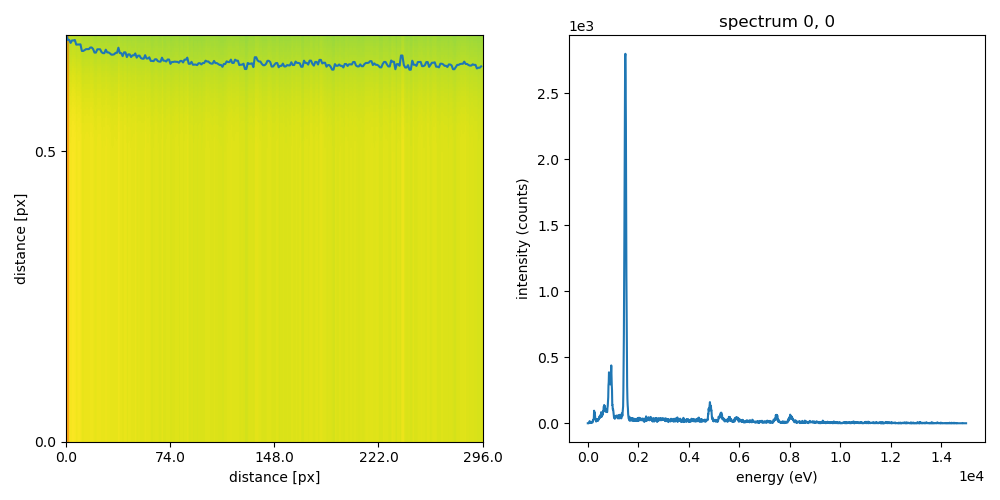

In [21]:
import sidpy
prof = get_profile(chooser.dataset, line)
v = prof.plot(figsize=(10,5))

v.axes[0].set_aspect('auto')
v.axes[0].set_ylim(0,.7)
v.axes[0].plot(prof[:,0,:700].sum(axis=1)/prof[:,0,:700].sum(axis=1).max()*.7)



In [22]:
line.set_linewidth(200)

In [66]:

plt.close('all')
line.line_verts

array([[352.50376046,  42.92113548],
       [383.76154697,  67.88011748],
       [100.84653548, 422.19332739],
       [ 69.58874897, 397.23434538]])

In [6]:
image_chooser = pyTEMlib.file_tools.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('RCOB-3,5Zn_Area5_LiveMap1_SpectrumImage: RCOB-3,5Zn_Area5_Li…

In [7]:
survey_image_chooser = pyTEMlib.file_tools.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('RCOB-3,5Zn_Area5_LiveMap1_SpectrumImage: RCOB-3,5Zn_Area5_Li…

sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<array, shape=(400, 512, 1500), dtype=uint8, chunksize=(400, 512, 655), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  distance (nm) of size (400,)
y:  distance (nm) of size (512,)
energy_scale:  energy (eV) of size (1500,)
 with metadata: ['experiment']

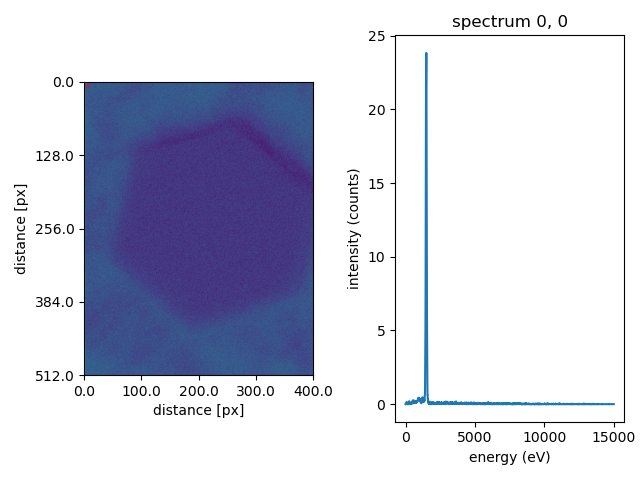

In [8]:
v = chooser.dataset.plot()
chooser.dataset.view.set_bin(8)
chooser.dataset

In [152]:
 chooser.dataset.metadata['experiment']['detector']

{'live_time': array([1310.72], dtype=float32),
 'tilt_angle': array([45.], dtype=float32),
 'take_off_angle': array([73.17], dtype=float32),
 'resolution': array([124.43575], dtype=float32),
 'Al_thickness': array([3.e-08], dtype=float32),
 'Be_thickness': array([0.], dtype=float32),
 'Par_thickness': array([0.], dtype=float32),
 'Au_thickness': array([3.e-08], dtype=float32),
 'Si_dead_layer_thickness': array([3.e-08], dtype=float32),
 'Si_live_thickness': array([0.05], dtype=float32),
 'x_ray_incident_angle': array([3.8146973e-06], dtype=float32),
 'azimuth_angle': array([29.], dtype=float32),
 'elevation_angle': array([32.], dtype=float32),
 'b_coefficient': array([0.6055], dtype=float32),
 'c_coefficient': array([1.], dtype=float32),
 'start_channel': 10}

[15000.]


([<matplotlib.lines.Line2D at 0x2042e2d8910>],)

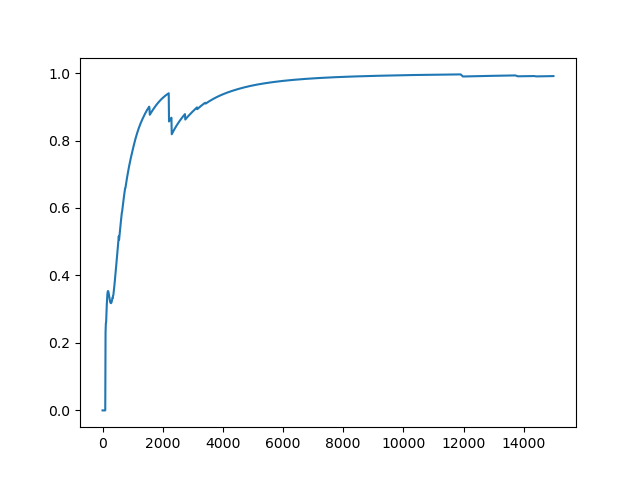

In [12]:
tags = chooser.dataset.metadata['experiment']
spectrum = prof[0,0]
spectrum.metadata = chooser.dataset.metadata
tags['acceleration_voltage_V'] = tags['microscope']['acceleration_voltage_V']
print(tags['acceleration_voltage_V'])
start = np.searchsorted(spectrum.energy_scale, 150)
detector_efficiency = np.zeros(len(spectrum))
detector_efficiency+= pyTEMlib.eds_tools.detector_response(spectrum)
plt.figure()
plt.plot(spectrum.energy_scale, detector_efficiency), 

## Fit Spectrum


  0%|          | 0/296 [00:00<?, ?it/s]

C:\Users\gduscher\AppData\Local\anaconda3\envs\py11\Lib\site-packages\scipy\optimize\_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 5600.
  warnings.warn(errors[info][0], RuntimeWarning)


[1.47242167e+09 6.33209968e-01 9.30698119e+05 3.08945689e+00]


(array([ 2.64692730e+02,  2.50589424e+02,  1.09388758e+03,  3.23841099e+03,
         1.77619286e+04,  7.90081155e+02,  2.96720773e+03,  8.21264399e+01,
         4.72609747e+02, -1.35137299e+01,  5.31435465e+02,  7.92168492e+02,
         1.53202679e+06, -1.53177519e+06,  3.29513784e+03,  4.91065997e+02,
         2.90844752e+02,  8.95559670e+01,  8.22172808e+01, -4.54702948e+02,
         6.22224550e+01,  1.25717238e+02,  1.06841776e+02]),
 15000.0)

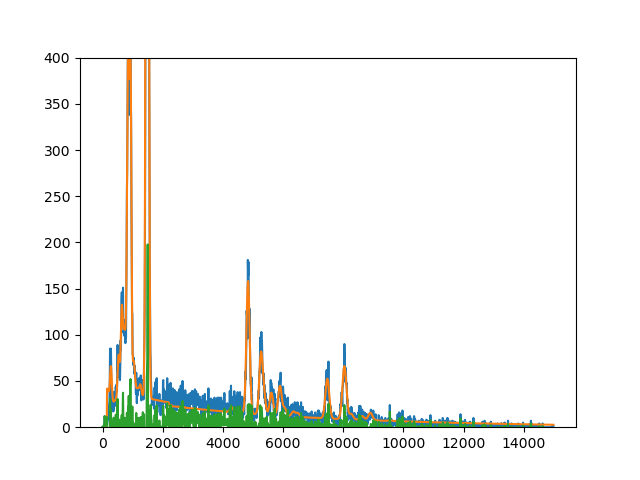

In [23]:
elements = ['C', 'O', 'Cu',  'Al',  'Ni', 'Zn', 'Mn', 'Ce', 'Mg']
spectrum = prof[0,0]
spectrum.metadata = chooser.dataset.metadata
spectrum.metadata['EDS'] = {}
pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements)
results = {}
from tqdm.notebook import trange, tqdm
for i in trange(len(prof[:,0])):
    spectrum = prof[i, 0]
    spectrum.metadata = chooser.dataset.metadata
    spectrum.metadata['EDS'] = {}
    peaks, p = pyTEMlib.eds_tools.fit_model(spectrum, elements, use_detector_efficiency= True)
    for element in chooser.dataset.metadata['EDS']['lines'].keys():
        for family in chooser.dataset.metadata['EDS']['lines'][element].keys():
            if family !='Z':
                if 'height' in chooser.dataset.metadata['EDS']['lines'][element][family].keys():
                    if element+': '+family not in results:
                        results[element+': '+family] = []
                    results[element+': '+family].append(chooser.dataset.metadata['EDS']['lines'][element][family]['height'])
                else: 
                    for line in  chooser.dataset.metadata['EDS']['lines'][element][family]:
                        if element+': '+line not in results:
                            results[element+': '+line] = []
                        results[element+': '+line].append(chooser.dataset.metadata['EDS']['lines'][element][family][line]['height'])
    

model = np.zeros(len(spectrum))
for i in range(len(p)-4):
    model += peaks[i]*p[i]
    pass
start = np.searchsorted(spectrum.energy_scale, 150)
energy_scale = spectrum.energy_scale[start:]
#p[-3:] = [100, 3, .007]
print(p[-4:])
E_0 = spectrum.metadata['experiment']['acceleration_voltage_V'][0]

#model[start:] += (detector_efficiency[start:] * (p[-3] + p[-2] * (E_0 - energy_scale) / energy_scale + p[-1] * (E_0-energy_scale) ** 2 / energy_scale))
bgd = p[-4] / (energy_scale + p[-3] * energy_scale ** 2 + p[-2] * energy_scale ** .5) - p[-1]

model[start:] += detector_efficiency[start:] * bgd
            
plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')

plt.plot(spectrum.energy_scale,model, label='model')
# plt.plot(spectrum.energy_scale[start:], bgd*detector_efficiency[start:])
plt.plot(spectrum.energy_scale,spectrum-model,  label='difference')
plt.ylim(0, 400)
p[:-4], E_0

In [99]:
for element in chooser.dataset.metadata['EDS']['lines'].keys():
    for family in chooser.dataset.metadata['EDS']['lines'][element].keys():
        if family !='Z':
            if 'height' in chooser.dataset.metadata['EDS']['lines'][element][family].keys():
                print(element, family, chooser.dataset.metadata['EDS']['lines'][element][family]['height'])
            else: 
                for line in  chooser.dataset.metadata['EDS']['lines'][element][family]:
                    print(element, line, chooser.dataset.metadata['EDS']['lines'][element][family][line]['height'])

C K-L2 719.7275004272193
O K-family 709.4224468971654
Cu K-family 1241.7096230109366
Cu L-family 3872.996900589313
Al K-family 53503.87631535529
Ni K-family 906.9432232071098
Ni L-family 3245.950888560075
Zn K-family 430.2158311157366
Zn L-family 897.58696601617
Zn L1-M3 13.582597432983146
Mn K-family 823.6062282699341
Mn L-family 1215.3640487509754
Mn L1-M3 -2511058034.947838
Mn L1-M2 2511058511.659821
Ce L-family 3708.887162520466
Ce M-family 879.714436584347
Ce L1-M3 389.7321484517518
Ce L1-M2 110.57470235331704
Ce L1-N3 361.09994964743817
Ce M2-N1 -4.922729278910817
Ce M2-N4 667.5528576928172
Ce M3-N5 565.4361020732148


dict_keys(['C: K-L2', 'O: K-family', 'Cu: K-family', 'Cu: L-family', 'Al: K-family', 'Ni: K-family', 'Ni: L-family', 'Zn: K-family', 'Zn: L-family', 'Zn: L1-M3', 'Mn: K-family', 'Mn: L-family', 'Mn: L1-M3', 'Mn: L1-M2', 'Ce: L-family', 'Ce: M-family', 'Ce: L1-M3', 'Ce: L1-M2', 'Ce: L1-N3', 'Ce: M2-N1', 'Ce: M2-N4', 'Ce: M3-N5', 'Mg: K-family'])


27

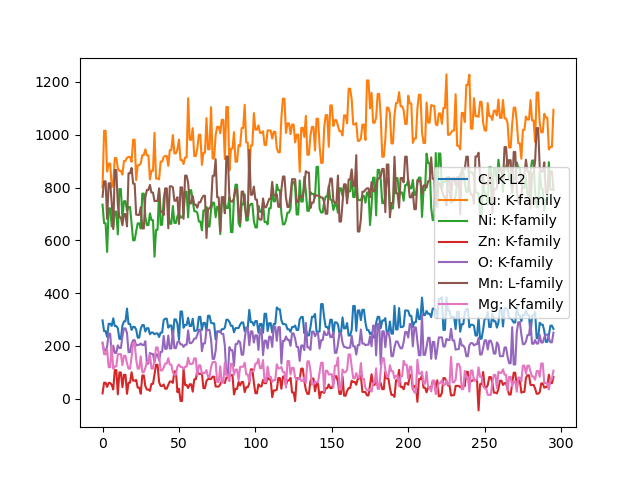

In [24]:
print(results.keys())
plt.figure()
for key in ['C: K-L2',   'Cu: K-family', 'Ni: K-family',  'Zn: K-family', 'O: K-family', 'Mn: L-family', 'Mg: K-family']:
    plt.plot(results[key], label=key)
plt.legend()
len(p)

dict_keys(['C: K-L2', 'O: K-family', 'Cu: K-family', 'Cu: L-family', 'Al: K-family', 'Ni: K-family', 'Ni: L-family', 'Zn: K-family', 'Zn: L-family', 'Zn: L1-M3', 'Mn: K-family', 'Mn: L-family', 'Mn: L1-M3', 'Mn: L1-M2', 'Ce: L-family', 'Ce: M-family', 'Ce: L1-M3', 'Ce: L1-M2', 'Ce: L1-N3', 'Ce: M2-N1', 'Ce: M2-N4', 'Ce: M3-N5', 'Mg: K-family'])


27

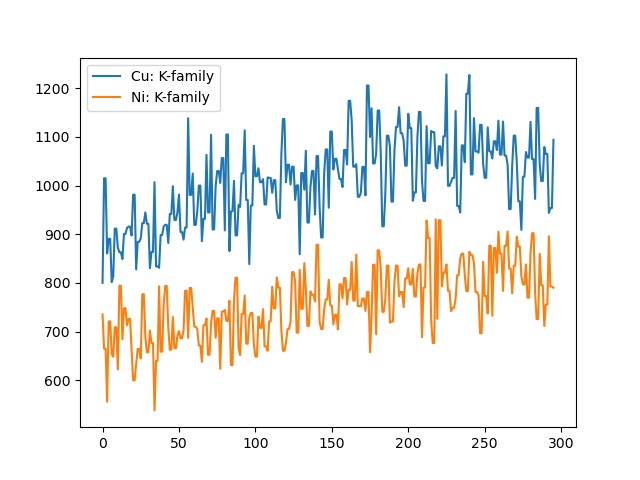

In [25]:
print(results.keys())
plt.figure()
for key in ['Cu: K-family', 'Ni: K-family']:
    plt.plot(results[key], label=key)
plt.legend()
len(p)

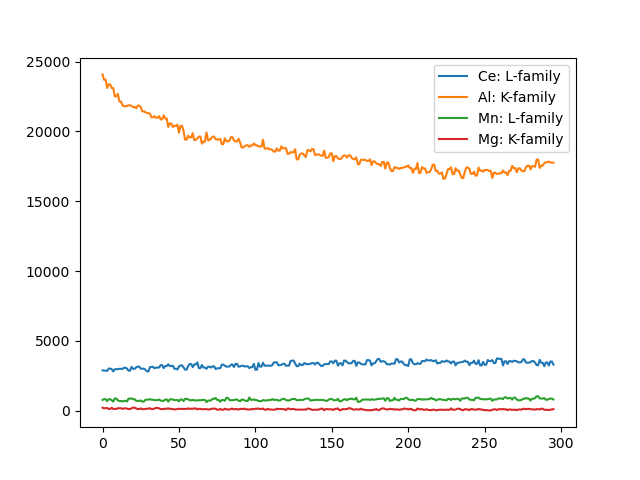

In [26]:
plt.figure()
for key in ['Ce: L-family', 'Al: K-family', 'Mn: L-family', 'Mg: K-family']:
    plt.plot(results[key], label=key)
plt.legend()

In [160]:
pyTEMlib.eds_tools.get_phases(chooser.dataset, number_of_phases=5)
fig = pyTEMlib.eds_tools.plot_phases(chooser.dataset, image_chooser.dataset, survey_image_chooser.dataset)

AttributeError: 'NoneType' object has no attribute 'split'

## Spectrum Image
Select the HAADF image reference

In [1142]:

# elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)


NameError: name 'minor_peaks' is not defined